In [1]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-10-11 12:05:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 74.125.24.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  77.1MB/s    in 6.9s    

2022-10-11 12:05:40 (71.5 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [2]:
import os
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data.zip"):
  print("There are {} directories and {} images in {}".format(len(dirnames),len(filenames),(dirpath)))

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"
IMG_SIZE = (224, 224) 
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=32) 
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")


Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


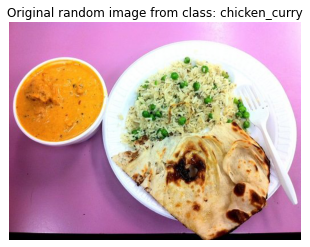

In [7]:
#viewing random image
target_class = random.choice(train_data.class_names)
target_dir = "10_food_classes_all_data/train/" + target_class
random_image = random.choice(os.listdir(target_dir)) 
random_image_path = target_dir + "/" + random_image 
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

In [8]:
# data augmentation layer  
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
], name ="data_augmentation")

In [9]:
#using functional api to create the model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

x = data_augmentation(inputs)

x = base_model(x,training=False)

x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)


16719872/16705208 [==============================] - 0s 0us/step
After GlobalAveragePooling2D(): (None, 1280)


In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [11]:
#creating model checkpoint
checkpoint_path = "model_checkpoints_weights/checkpoint.ckpt" 
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True, 
                                                         save_freq="epoch",
                                                         verbose=1)

In [13]:
history = model.fit(train_data,epochs=6, validation_data=test_data, validation_steps=int(0.25* len(test_data)),
                                          callbacks=[checkpoint_callback])

Epoch 1/6
235/235 [==============================] - ETA: 0s - loss: 0.7242 - accuracy: 0.7785
Epoch 1: val_loss improved from inf to 0.41897, saving model to model_checkpoints_weights/checkpoint.ckpt
235/235 [==============================] - 21s 88ms/step - loss: 0.7242 - accuracy: 0.7785 - val_loss: 0.4190 - val_accuracy: 0.8816
Epoch 2/6
234/235 [============================>.] - ETA: 0s - loss: 0.6176 - accuracy: 0.8069
Epoch 2: val_loss improved from 0.41897 to 0.36101, saving model to model_checkpoints_weights/checkpoint.ckpt
235/235 [==============================] - 20s 82ms/step - loss: 0.6173 - accuracy: 0.8069 - val_loss: 0.3610 - val_accuracy: 0.8980
Epoch 3/6
234/235 [============================>.] - ETA: 0s - loss: 0.5713 - accuracy: 0.8222
Epoch 3: val_loss improved from 0.36101 to 0.34737, saving model to model_checkpoints_weights/checkpoint.ckpt
235/235 [==============================] - 21s 88ms/step - loss: 0.5709 - accuracy: 0.8224 - val_loss: 0.3474 - val_accurac

In [14]:
import pandas as pd
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(len(history.history['loss']))
  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

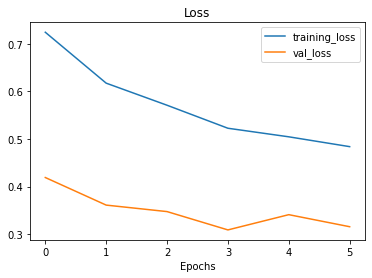

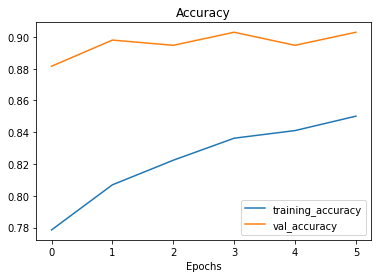

In [15]:
plot_loss_curves(history)

In [16]:
model.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.3352 - accuracy: 0.8948


[0.3352395296096802, 0.8948000073432922]

In [17]:
#loading checkpoint weights
model.load_weights(checkpoint_path)

In [18]:
#unfreezing upper layers for fine tuning
base_model.trainable = True
for layer in base_model.layers[:-10]:
  layer.trainable = False

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [19]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [20]:
history_FT = model.fit(train_data,epochs=10,validation_data=test_data,initial_epoch=history.epoch[-1],validation_steps=int(0.3 * len(test_data)),)

Epoch 6/10
235/235 [==============================] - 29s 91ms/step - loss: 0.4925 - accuracy: 0.8419 - val_loss: 0.3201 - val_accuracy: 0.8954
Epoch 7/10
235/235 [==============================] - 20s 85ms/step - loss: 0.4393 - accuracy: 0.8585 - val_loss: 0.2754 - val_accuracy: 0.9090
Epoch 8/10
235/235 [==============================] - 20s 85ms/step - loss: 0.3966 - accuracy: 0.8693 - val_loss: 0.2796 - val_accuracy: 0.9117
Epoch 9/10
235/235 [==============================] - 20s 85ms/step - loss: 0.3569 - accuracy: 0.8856 - val_loss: 0.2937 - val_accuracy: 0.9049
Epoch 10/10
235/235 [==============================] - 21s 88ms/step - loss: 0.3290 - accuracy: 0.8948 - val_loss: 0.2655 - val_accuracy: 0.9185


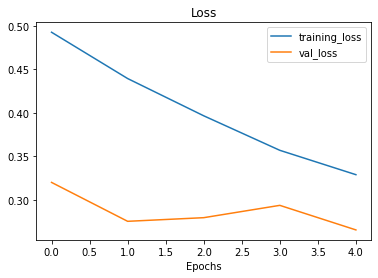

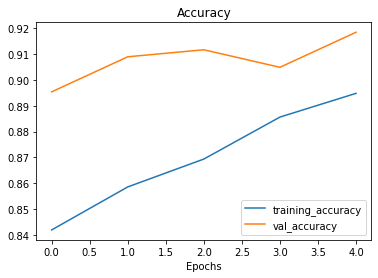

In [21]:
plot_loss_curves(history_FT)

In [22]:
model.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.2978 - accuracy: 0.9052


[0.2978333532810211, 0.9052000045776367]